In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from skimage import io
from super_gradients.common.object_names import Models
from super_gradients.training import models

from config import SAM_PATH

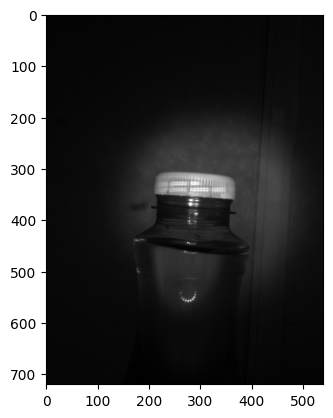

In [4]:
test_img = io.imread('../0006.jpg')
plt.imshow(test_img, cmap='gray')

In [5]:
net = models.get(Models.YOLO_NAS_S, pretrained_weights="coco")

In [6]:
# image grayscale to hwc
test_img = np.repeat(test_img[:, :, np.newaxis], 3, axis=2)
results = [r for r in net.predict([test_img], conf=0.7)][0]

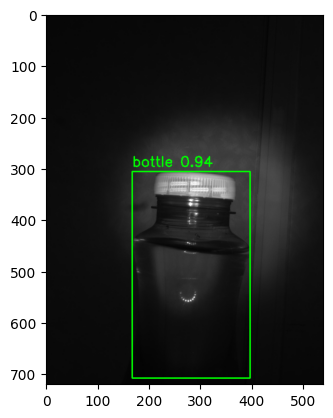

In [7]:
class_names = results.class_names
labels = results.prediction.labels.astype(int)
confidence = results.prediction.confidence
bboxes = results.prediction.bboxes_xyxy

for i, (label, conf, bbox) in enumerate(zip(labels, confidence, bboxes)):
    print(f"Found {class_names[label]} with confidence {conf} at {bbox}")
    # draw the bounding box
    x1, y1, x2, y2 = bbox.astype(int)
    cv2.rectangle(test_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # draw the label
    cv2.putText(test_img, f"{class_names[label]} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

plt.imshow(test_img)

In [8]:
sub_img = test_img[y1:y2, x1:x2]

In [9]:
# segment sub_image with SAM
sam = sam_model_registry["vit_b"](checkpoint=SAM_PATH)
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [10]:
predictor.set_image(sub_img)

In [11]:
input_point = np.array([
    [10, sub_img.shape[1] / 2],
    [sub_img.shape[0] / 2, sub_img.shape[1] / 2],
    [sub_img.shape[0] - 10, sub_img.shape[1] / 2],
    [10, 10],
    [10, sub_img.shape[1] - 10],
])

input_label = np.array([1, 0, 0, 0, 0])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

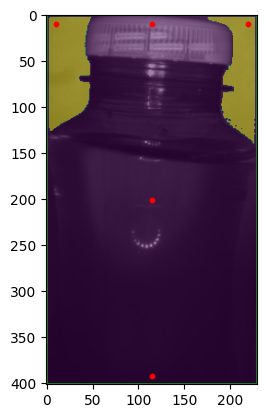

In [12]:
# show original image with a point at input_point
plt.imshow(sub_img)
plt.scatter(input_point[:, 1], input_point[:, 0], c='r', s=10)
# show mask
plt.imshow(masks[0], alpha=0.5)

Les résultats sont mauvais: SAM n'arrive pas à détourer le bouchon.

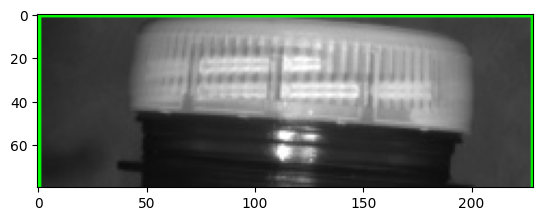

In [13]:
# crop out the cap (1/6 of the image)
cap = sub_img[:sub_img.shape[0] // 5, :]

plt.imshow(cap)

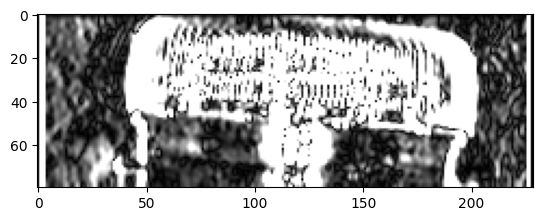

In [14]:
# compute the horizontal derivative to detect edges
cap = cv2.cvtColor(cap, cv2.COLOR_RGB2GRAY)
cap = cv2.Sobel(cap, cv2.CV_64F, 1, 0, ksize=5)
cap = cv2.convertScaleAbs(cap)

plt.imshow(cap, cmap='gray')

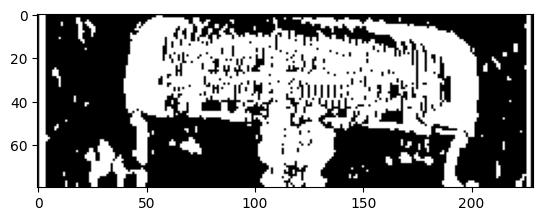

In [15]:
# threshold the image
_, cap = cv2.threshold(cap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(cap, cmap='gray')

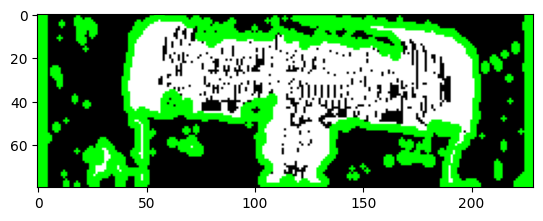

In [16]:
# find contours and draw them
contours, _ = cv2.findContours(cap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cap = cv2.cvtColor(cap, cv2.COLOR_GRAY2RGB)
cv2.drawContours(cap, contours, -1, (0, 255, 0), 2)

plt.imshow(cap)